Deep Learning Recurrent Neural Network

Development of a recurrent network to solve a text classification problem. The feature to be predicted is the classification accuracy of a Amazon Reviews for Sentiment Analysis dataset.

The notebook is divided in sections with the following structure:
1. Imports, declarations and configuration
2. Dataset
3. Testing </br>
    Base Model</br>
    Optimizer Selection</br>
    Test max features</br>
    Test length</br>
    Test embedding size</br>
    Complex models</br>
    Regularization</br>
    Optimizing learning rate</br>
4. Results

## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [2]:
# Size of the vocabulary. Value selected after testing in subsection max_feature testing
#maxFeatures = 2500
maxFeatures = 100000

# Maximum length of the text for each sample. If the text of a sample is shorter than seqLength, 
# TextVectorization will add 0 at the end to complete the input vector. This is to give the embedding layer a fixed length in the sentences.
# If seq_Length = 0, the value returned from the readData function will be use. 
# Its calculated with the formula average(lineLength) + 2*np.std(lineLength) where lineLength is an array with all the length of the lines of the dataset.
# Value confirmed after testing in subsection length testing
seq_Length = 0

# The embedding dimension. Value selected after testing in subsection embedding size testing
#emb_dim = 128
emb_dim = 64

# Size of the batch use in the fit function, it determines the number of samples used in each iteration of training. 
# We begin with a long value and reduce it when we start testing complex models.
# A larger batch size faster training, but less accurate. A smaller batch size slower training, but more accurate.
batch_size=512

# If activated test the simple models
test_simple = False
# If activated test the optimizers
test_optimizer = False
# If activated test max features
test_maxfeatures = False
# If activated test different lengths for the sequence
test_length = False
# If activated test the embedding size
test_embedding = False
# If activated test the complex models
test_complex = False
# If activated test the regularizations and optimizations
test_reg = False

## 2. Dataset

In this section we load the dataset for training and validation with the provided functions. </br>

In [3]:
#reads a file. Each line has the format: label text
#Returns a list with the text and a list with the labels
### We change the removeprefix method for replace as it was not compatible with our python version
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))
    
    for i, aLine in enumerate(lines):    
        if not aLine:
            break  
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            ### We change the removeprefix method for replace as it was not compatible with our python version
            #textData.append(aLine.removeprefix("__label__1 "))
            textData.append(aLine.replace("__label__1 ",""))

        elif(label == "__label__2"):
            textLabel.append(1)
            ### We change the removeprefix method for replace as it was not compatible with our python version
            #textData.append(aLine.removeprefix("__label__2 "))
            textData.append(aLine.replace("__label__2 ",""))

        else:
            print("\nError in readData: ", i, aLine)
            exit()
    
    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))

In [4]:
def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    #transforms text input to int input based on the vocabulary
    #max_tokens = maxFeatures is the size of the vocabulary
    #output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
    precLayer = layers.experimental.preprocessing.TextVectorization(max_tokens = maxFeatures, 
        standardize =  'lower_and_strip_punctuation', split = 'whitespace', output_mode = 'int', 
        output_sequence_length =  seqLength)
    precLayer.adapt(x_train)
    #print(precLayer.get_vocabulary())
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    #print(x_train_int)
    #print(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)
    #print(x_test_int)
    #print(y_test)

    return x_train_int, y_train, x_test_int, y_test

In [5]:
x_train, y_train, seqLength = readData("dataset/train_small.txt")
x_test, y_test, tmp = readData("dataset/test_small.txt")

# If no seq length is configurated, use the one returned from the function
# int(np.average(lineLength)+2*np.std(lineLength))
if seq_Length == 0:
    seq_Length = seqLength

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, maxFeatures, seq_Length)

In [6]:
unique_words = set()

for item in x_train:
    words = item.split()
    unique_words.update(words)

count_unique_words = len(unique_words)

print("Total number of unique words in the train set: ", count_unique_words)

Total number of unique words in the train set:  147917


In [7]:
max_length = 0
for i in x_train:
    if (len(i) > max_length):
        max_length = len(i)

print("Max length of the words in the train set:", max_length)

Max length of the words in the train set: 1015


## 3. Testing

In this section we experiment with different datasets, optimizers, models, hyperparameters and regularization to define our final model. Each sub section can be enable/disable from the configuration section.

### Supplementary functions and default configuration
Supplementary functions to plot the data, return some predefined model, callback and optimizer.

In [8]:
# Function to print the results of the training
def print_plot(name, history, best_loss, best_accuracy):
    # summarize history for train accuracy
    fig, axs = plt.subplots(1,2)
    fig.suptitle(name + ' - Training and validation')
    fig.set_figwidth(10)
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(best_loss)
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['Loss', 'Val_loss'])
    axs[0].set_ylim([0, 0.7])
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(best_accuracy)
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['Accuracy', 'Val_accuracy'])
    axs[1].set_ylim([0.5, 1])
    plt.savefig('images/' + name + '.png')
    plt.show()

In [9]:
# Function to get the callbacks for the test of the models
def get_callbacks(name, patience=10):
    # This is to save computational power as a 10 epoch value without improvement we know is not going to get better
    return [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
            # Save only the best model
            keras.callbacks.ModelCheckpoint(filepath="models/" + name + ".keras",save_best_only=True,monitor="val_loss", verbose=1)
            ]

In [10]:
# Function to get the basic model
def get_base_model(max_features=2000, embedding_dimension=128):
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(max_features, embedding_dimension, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(8, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(8))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [11]:
# Function to get the best optimizer (obtained in the test optimizer section)
def get_optimizer(lr=0.001):
    return optimizers.Adamax(learning_rate=lr)

### Base models

In this subsection we start experiment with some basic models.

In [12]:
if test_simple == True:
    name = 'SimpleRNN'
    inputs = keras.Input(shape=(None,), dtype="int32")    
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.SimpleRNN(8, return_sequences=True)(x)   
    x = layers.SimpleRNN(8)(x)   
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [13]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f} - ",f"Best val Accuracy: {res:.4f} - ")

When we run the model, we save the images and the model in disk so we can use the model later if we need it and to show the result of the training in a markdown cell. In this way, we don't need to rerun the cell to show the results.

![](images/SimpleRNN.png)

**SimpleGRU**

In [14]:
if test_simple == True:
    name = 'SimpleGRU'
    inputs = keras.Input(shape=(None,), dtype="int32")    
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.GRU(8, return_sequences=True)(x)   
    x = layers.GRU(8)(x) 
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [15]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f} - ",f"Best val Accuracy: {res:.4f} - ")

![](images/SimpleGRU.png)

**SimpleLSTM**

In [16]:
if test_simple == True:
    name = "SimpleLSTM"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.LSTM(8, return_sequences=True)(x)   
    x = layers.LSTM(8)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [17]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f} - ",f"Best val Accuracy: {res:.4f} - ")

![](images/SimpleLSTM.png)

**SimpleBidireccional**

In [18]:
if test_simple == True:
    name = "SimpleBidireccionalLSTM"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(8, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(8))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [19]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f} - ",f"Best val Accuracy: {res:.4f} - ")

![](images/SimpleBidireccionalLSTM.png)

**SimpleBidireccionalGRU**

In [20]:
if test_simple == True:
    name = "SimpleBidireccionalGRU"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(8, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(8))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [21]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccionalGRU.png)

The result of this model are a little better than the ones in the previous experiments, 1% more over the simple GRU model and 0.5% against the bidireccional LSTM model. 

As we can see, both GRU and LSTM have good results for this particular problem. We decided to focus on optimizing the GRU network to improve its performance as it has a faster time for training and a little better metric that the LSTM. For the rest of the work we continued with the GRU network to explore various optimizations and try to obtain better results.


### Optimizer Selection

In this sub section we determinate which optimizer to use. 

In [22]:
# Instance the optimizers
if test_optimizer == True:
    opt_names = ["RMSprop","adam","Adamax"]
    opt_values = [optimizers.RMSprop(learning_rate=0.001),optimizers.Adam(learning_rate=0.001), optimizers.Adamax(learning_rate=0.001)]
    test_history= []

In [23]:
# Train the models
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        model = get_base_model(max_features=maxFeatures, embedding_dimension=emb_dim)

        model.compile(optimizer=opt_values[i], loss="binary_crossentropy", metrics=["accuracy"])
        print("Testing optimizer:",opt_names[i])
        
        test_history.append(model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(opt_names[i])))

In [24]:
# Generate the results
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        model = keras.models.load_model("models/" + opt_names[i] + ".keras") 
        res = model.evaluate(x=x_test_int, y=y_test)[1]
        print_plot(opt_names[i], test_history[i], f"Best val Loss: {min(test_history[i].history['val_loss']):.4f} - ",f"Best val Accuracy: {res:.4f} - ")

![](images/Rmsprop.png)

![](images/Adam.png)

![](images/Adamax.png)

As we can see in the three plots shown before, all optimizers have similar results in the range of 87% accuracy. Adamax optimizer was the one with the best results, that's why we will use it for the rest of the work. In a matter of fact, the other optimizers are good alternatives and perform closely to Adamax.

### Test max features

In this sub section we try different size of maximum features.

In [25]:
if test_maxfeatures == True:
    opt_names = ["max_500","max_1000","max_2000","max_2500","max_3000","max_5000","max_8000","max_15000","max_25000","max_40000","max_80000","max_100000","max_120000","max_147917"]
    opt_values = [500,1000,2000,2500,3000,5000,8000,15000,25000,40000,80000,100000,120000,147917]
    test_history= []

In [26]:
# Train the models
if test_maxfeatures == True:
    for i in range(0,len(opt_names)):
        x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, opt_values[i], seq_Length)

        model = get_base_model(max_features=opt_values[i], embedding_dimension=emb_dim)

        model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
        print("Testing value:",opt_names[i])
        
        test_history.append(model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(opt_names[i])))

In [27]:
# Generate the results
if test_maxfeatures == True:
    for i in range(0,len(opt_names)):
        model = keras.models.load_model("models/" + opt_names[i] + ".keras") 
        res = model.evaluate(x=x_test_int, y=y_test)[1]
        print_plot(opt_names[i], test_history[i], f"Best val Loss: {min(test_history[i].history['val_loss']):.4f} - ",f"Best val Accuracy: {res:.4f} - ")

![](images/max_1000.png)

![](images/max_1500.png)

![](images/max_2000.png)

![](images/max_2500.png)

![](images/max_3000.png)

![](images/max_4000.png)

![](images/max_5000.png)

![](images/max_10000.png)

![](images/max_20000.png)

![](images/max_40000.png)

![](images/max_80000.png)

![](images/max_100000.png)

![](images/max_120000.png)

![](images/max_147917.png)

### Test length

In this sub section we try different sizes for the length.

In [29]:
if test_length == True:
    x_train, y_train, seqLength = readData("dataset/train_small.txt")
    x_test, y_test, tmp = readData("dataset/test_small.txt")

    opt_names = ["length_50","length_100","length_200","length_300","length_400","length_1000"]
    opt_values = [50,100,200,300,400,1000]

    # int(np.average(lineLength)+2*np.std(lineLength)) = 166
    opt_names.append("length_" + str(seq_Length))
    opt_values.append(seqLength)

    test_history= []

In [30]:
# Train the models
if test_length == True:
    for i in range(0,len(opt_names)):
        model = get_base_model(max_features=maxFeatures, embedding_dimension=emb_dim)

        model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
        print("Testing value:",opt_names[i])

        x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, maxFeatures, opt_values[i])
        
        test_history.append(model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(opt_names[i])))

In [31]:
# Generate the results
if test_length == True:
    for i in range(0,len(opt_names)):
        model = keras.models.load_model("models/" + opt_names[i] + ".keras") 
        res = model.evaluate(x=x_test_int, y=y_test)[1]
        print_plot(opt_names[i], test_history[i], f"Best val Loss: {min(test_history[i].history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/length_50.png)

![](images/length_100.png)

![](images/length_166.png)

![](images/length_200.png)

![](images/length_300.png)

![](images/length_400.png)

![](images/length_1000.png)

### Test embedding size

In this sub section we will experiment different models with different embedding layer's size.

In [32]:
if test_embedding == True:
    # More than 1024 we loss the GPU
    opt_names = ["emb_16","emb_32","emb_64","emb_128","emb_256","emb_512"]
    opt_values = [16,32,64,128,256,512]
    test_history= []

In [33]:
# Train the models
if test_embedding == True:
    for i in range(0,len(opt_names)):
        model = get_base_model(max_features=maxFeatures, embedding_dimension=opt_values[i])

        model.compile(optimizer=get_optimizer(), loss="binary_crossentropy", metrics=["accuracy"])
        print("Testing value:",opt_names[i])
        
        test_history.append(model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(opt_names[i])))

In [34]:
# Generate the results
if test_embedding == True:
    for i in range(0,len(opt_names)):
        model = keras.models.load_model("models/" + opt_names[i] + ".keras") 
        res = model.evaluate(x=x_test_int, y=y_test)[1]
        print_plot(opt_names[i], test_history[i], f"Best val Loss: {min(test_history[i].history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/emb_16.png)

![](images/emb_32.png)

![](images/emb_64.png)

![](images/emb_128.png)

![](images/emb_256.png)

![](images/emb_512.png)

### Complex models

In this subsection we will try more complex models using our bidirectional GRU as a base for the new models and with the previous hyperparameters selected.

As we started testing more final models, we decide to also reduce the batch size and learning rate so the model while converge more slowly but potentially to a better minimum loss even if it take more time to train.

In [35]:
batch_size = 128
lr=0.0001

Our first test is actually a grid search for the best parameters for the units of the bidirectional gru contained in the architecture that we already defined. In this case we use two for instruction with values of 8, 16 and 32. Increasing the number of units for GRU layers will result in a more complex model that could better learn the underlying patterns of our text data and deduct more accurately the relationship between them. We will see if this approach give us a more performant model.

In [36]:
if test_complex == True:
    grid_history = []
    units1 = [8, 16, 32]
    units2 = [8, 16, 32]

    for i in range(0,len(units1)):
        for ii in range(0, len(units2)):
            name = "SimpleBidireccional_" + str(units1[i]) + "_" + str(units2[ii])
            print("Testing value:",name)

            inputs = keras.Input(shape=(None,), dtype="int32")
            x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
            x = layers.Bidirectional(layers.GRU(units1[i], return_sequences=True))(x)
            x = layers.Bidirectional(layers.GRU(units2[ii]))(x)
            outputs = layers.Dense(1, activation="sigmoid")(x)
            model = keras.Model(inputs, outputs)

            model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
            grid_history.append(model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name)))

In [37]:
if test_complex == True:
    iii = 0
    for i in range(0,len(units1)):
        for ii in range(0, len(units2)):
            name = "SimpleBidireccional_" + str(units1[i]) + "_" + str(units2[ii])
            model = keras.models.load_model("models/" + name + ".keras") 
            res = model.evaluate(x=x_test_int, y=y_test)[1]

            print_plot(name, grid_history[iii], f"Best val Loss: {min(grid_history[iii].history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")
            iii = iii+1

![](images/SimpleBidireccional_8_8.png)

![](images/SimpleBidireccional_8_16.png)

![](images/SimpleBidireccional_8_32.png)

![](images/SimpleBidireccional_16_8.png)

![](images/SimpleBidireccional_16_16.png)

![](images/SimpleBidireccional_16_32.png)

![](images/SimpleBidireccional_32_8.png)

![](images/SimpleBidireccional_32_16.png)

![](images/SimpleBidireccional_32_32.png)

In [38]:
if test_complex == True:
    name = "SimpleBidireccional_Dense"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    x = layers.Dense(16)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [39]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional_Dense.png)

As we can see in the plot, the results were not better than the ones we were having from our previous model.

In [40]:
if test_complex == True:
    name = "TripleBidireccional"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [41]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/TripleBidireccional.png)

As we can see in the plot, the results were not better that the ones we were having from our previous model.

In [42]:
if test_complex == True:
    name = "SimpleBidireccionalGRU_LSTM"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.LSTM(16)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [43]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional_LSTM.png)

As we can see in the plot, the results were not better that the ones we were having from our previous model.

In [44]:
if test_complex == True:
    name = "SimpleBidireccionalGRU_Gru"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.GRU(16)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [45]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

As we can see in the plot, we have more epochs to train our model, but the final results were not better that the ones we were having from the previous models.

![](images/SimpleBidireccional_Gru.png)

In [46]:
if test_complex == True:
    name = "SimpleBidireccionalLSTM_GRU"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=50, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [47]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccionalLSTM_GRU.png)

As we can see in the plot, the results were not better that the ones we were having from our previous model.

The best architecture after this experimentation is the same as the previous section but in this case with 16 units on each bidirectional GRU.

### Regularization

In this section we try different regularization techniques to improve the results of our model.

In [48]:
if test_reg == True:
    name = "SimpleBidireccional16_dropout_recdropout"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.GRU(16, dropout=0.2 , recurrent_dropout=0.2, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, dropout=0.2 , recurrent_dropout=0.2))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [49]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_dropout_recdropout.png)

In [50]:
if test_reg == True:
    name = "SimpleBidireccional16_embdropout"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [51]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_embdropout.png)

In [52]:
if test_reg == True:
    name = "SimpleBidireccional16_simpledropout"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [53]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_simpledropout.png)

In [54]:
if test_reg == True:
    name = "SimpleBidireccional16_dobledropout"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [55]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_dobledropout.png)

#### Normalization

Normalizing the inputs of some layers could help to reduce overfitting so for out next test we are going to add a batch normalization layer after each bidirectional layer.

In general is not recommended to use batch normalization with embedding layers, as the embedding layer produces a sparse output, meaning that many of the values in the output tensor are zero and this can lead to numerical instability when using batch normalization, so we wont add batch normalization after this type of layer.

In [56]:
if test_reg == True:
    name = "SimpleBidireccional16_norm"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [57]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_norm.png)

We can see that using a batch normalization layer after each GRU layer didn't improve the model so will we will discard this approach of regularization.

#### Weight decay

For our next test, we experiment with weight decay which works by adding an additional term to the loss function that penalizes large weights in the model. We use L1 (adds a penalty proportional to the absolute value of the weight coefficients), L2 (adds a penalty proportional to the square of the weight coefficients) regularization and a combination of both.

In [58]:
if test_reg == True:
    name = "SimpleBidireccional16_L1"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True, embeddings_regularizer=regularizers.l1(0.0001))(inputs)
    x = layers.Bidirectional(layers.GRU(16, kernel_regularizer=regularizers.l1(0.0001), return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, kernel_regularizer=regularizers.l1(0.0001)))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name, patience=20))

In [59]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_L1.png)

In [60]:
if test_reg == True:
    name = "SimpleBidireccional16_L2"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True, embeddings_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.Bidirectional(layers.GRU(16, kernel_regularizer=regularizers.l2(0.001), return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, kernel_regularizer=regularizers.l2(0.001)))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name, patience=20))

In [61]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_L2.png)

In [62]:
if test_reg == True:
    name = "SimpleBidireccional16_L1L2"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True, embeddings_regularizer=regularizers.l1_l2(l1=0.0001,l2=0.001))(inputs)
    x = layers.Bidirectional(layers.GRU(16, kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2=0.001), return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2=0.001)))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name, patience=20))

In [63]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_L1L2.png)

After the execution of this subsection, we can see that using only the L2 regularization gave the best metrics with 0.8828 of accuracy,  even over the combination of both L1 and L2 with 0.8775 of accuracy.

#### Combination

Next we test the combination of regularization techniques to see if we get better results than using them individually. We did not test dropout at the same time that batch normalization as they do not work well together. In fact, dropout could randomly drop out neurons that normalization is taking into account to make its calculations.
We decide to test the model with dropout, recurrent dropout and L2 as they give the better results in the previous experimentation of this notebook. 

In [64]:
if test_reg == True:
    name = "SimpleBidireccional16_drop_recdrop_L2"
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(maxFeatures, emb_dim, mask_zero=True, embeddings_regularizer=regularizers.l2(l2=0.001))(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.GRU(16, dropout=0.2 , recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(l2=0.001), return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16, dropout=0.2 , recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(l2=0.001)))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

In [65]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(x=x_test_int, y=y_test)[1]

    print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

![](images/SimpleBidireccional16_drop_recdrop_L2.png)

As we can see in the graph, the result of this model are very similar to the ones obtained in the simpleBidireccional16_dropout_recdropout one, which have a 88.58 against a 88.50 for our new experiment. We decide to keep this new model as our final model as adding the use of L2 will also give a better generalization than only using dropout.

Now that we have our final model, we will try to optimize it more in the next Optimizing learning rate section.

### Optimizing learning rate

In this subsection we do the fine tuning of the best model. 

After experimenting with different models and regularization techniques during the previous tests, we selected the final model to "tune it", this means, we train the model with a lower optimizer learning rate. As we have done before, we decided to also reduce the batch size.

In [66]:
batch_size = 64
lr = 0.000001

In [68]:
name = "FinalModel_lr000001"
model = keras.models.load_model("models/SimpleBidireccional16_drop_recdrop_L2.keras") 

model.compile(optimizer=get_optimizer(lr), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train_int, y_train, batch_size=batch_size, epochs=100, validation_data=(x_test_int, y_test), callbacks=get_callbacks(name))

Epoch 1/100
391/391 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9298
Epoch 1: val_loss improved from inf to 0.34670, saving model to models\FinalModel_lr00001.keras
391/391 [==============================] - 157s 372ms/step - loss: 0.2502 - accuracy: 0.9298 - val_loss: 0.3467 - val_accuracy: 0.8851
Epoch 2/100
391/391 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9305
Epoch 2: val_loss did not improve from 0.34670
391/391 [==============================] - 148s 379ms/step - loss: 0.2471 - accuracy: 0.9305 - val_loss: 0.3468 - val_accuracy: 0.8853
Epoch 3/100
391/391 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9306
Epoch 3: val_loss did not improve from 0.34670
391/391 [==============================] - 150s 384ms/step - loss: 0.2499 - accuracy: 0.9306 - val_loss: 0.3469 - val_accuracy: 0.8846
Epoch 4/100
391/391 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9304
Epoch 4: val_loss

In [72]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          6400000   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 32)         7872      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4800      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33    

782/782 [==============================] - 83s 104ms/step - loss: 0.3467 - accuracy: 0.8851


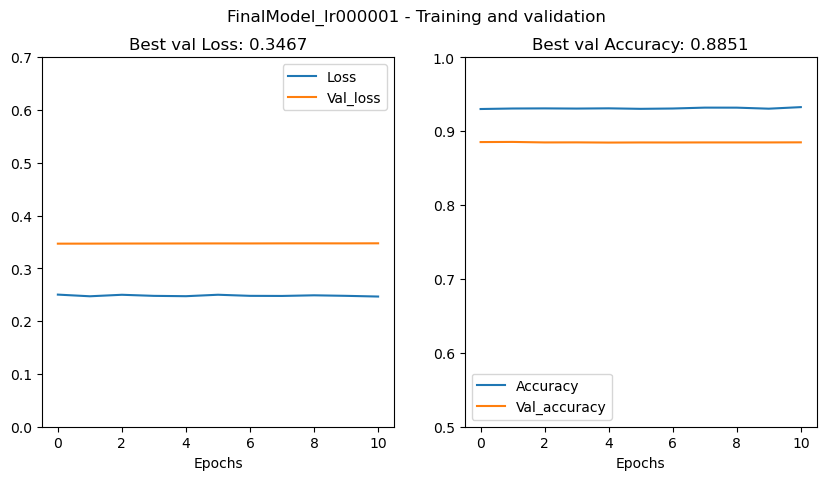

In [69]:
model = keras.models.load_model("models/" + name + ".keras") 
res = model.evaluate(x=x_test_int, y=y_test)[1]

print_plot(name, history, f"Best val Loss: {min(history.history['val_loss']):.4f}",f"Best val Accuracy: {res:.4f}")

The accuracy of the model increase only from 0.8850 to 0.8851. This is expected as when why starting testing more complex models, we also decided to reduce the learning rate and batch size, so the reach of a better minimum is limited.

## 4.Results

In this section we show the final results about the project.

Basic model - Model evaluation accuracy: 0.879
Optimizer selection - Model evaluation accuracy: 0.8794
Max features selection - Model evaluation accuracy: 0.8791
Length selection - Model evaluation accuracy: 0.8804
Embedding selection - Model evaluation accuracy: 0.8824
Complex model - Model evaluation accuracy: 0.8832
Complex model with regularization - Model evaluation accuracy: 0.885
Complex model with fine tuning - Model evaluation accuracy: 0.8851


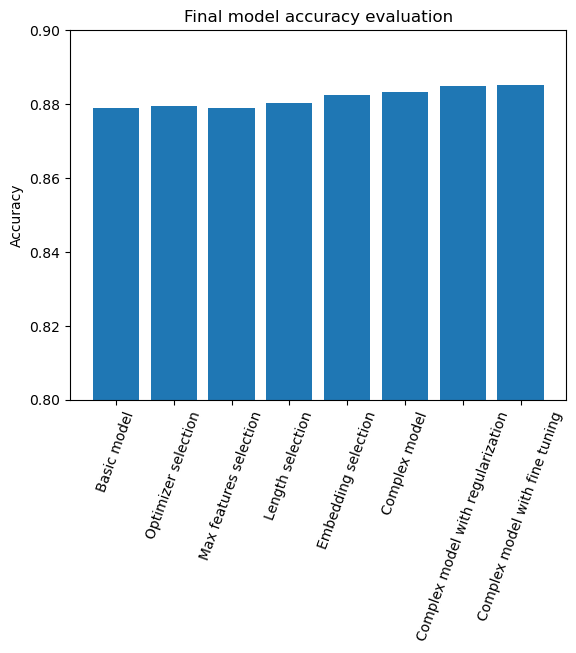

In [80]:
acc_models = [0.8790, 0.8794, 0.8791, 0.8804, 0.8824, 0.8832, 0.8850, 0.8851]
names = ["Basic model", "Optimizer selection", "Max features selection", "Length selection", 
         "Embedding selection", "Complex model", "Complex model with regularization", "Complex model with fine tuning"]

for i in range(0,len(acc_models)):
    print(names[i], '- Model evaluation accuracy:', acc_models[i])

plt.bar(names, acc_models)
plt.title('Final model accuracy evaluation')
plt.ylabel('Accuracy')
plt.tick_params(axis='x', rotation=70)
plt.ylim([0.8, 0.9])
plt.show()

In the above graphic we can see the evolution of our model thought the different steps that we set for our selection, first the test of different basic architectures, then the selection of the optimizer, the test of better hyperparameters and more complex models, the use of different regularization techniques and finally the fine tunning of our final model.

We can see how our metrics improve in most of the steps, except in the case of max features. In some sections we have models with better metrics, but we decide to select others that will theoretically have a better generalization.

In the final execution of our model, the testing accuracy was 0.8851.